In [109]:
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
tf.test.gpu_device_name()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import tensorflow as tf
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import time
import functools
import IPython.display as display



In [168]:
def vgg_input_resize(path_to_img,new_width=244,new_height=244):
  img = PIL.Image.open(path_to_img)
  img = np.expand_dims(np.array(img.resize((new_width,new_height))),axis = 0)
  #plt.imshow(style_image)
  return img

def load_img(path_to_img,max_dim = 512):
  img = PIL.Image.open(path_to_img)
  width,height = img.size
  new_width,new_height = 0,0
  if width >= height:
    new_width = max_dim
    new_height = round(new_width/width*height)
  else:
    new_height = max_dim
    new_width = round(new_height/height*width)

  img = np.expand_dims(np.array(img.resize((new_width,new_height))),axis = 0)
  #plt.imshow(style_image)
  return img

# Create a simple function to display an image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = np.squeeze(image, axis=0)

  #img = image.numpy()
  plt.imshow(image)
  if title:
    plt.title(title)


In [174]:
def sharpen_2(img,max_dim=512):
  #imageObject = tensor_to_image(img)
  if np.ndim(img)>3:
    img = np.squeeze(img, axis=0)
  img = PIL.Image.fromarray(img)
  sharpened1 = img.filter(ImageFilter.SHARPEN)
  sharpened2 = sharpened1.filter(ImageFilter.SHARPEN)  

  img = sharpened2
  width,height = img.size
  new_width,new_height = 0,0
  if width >= height:
    new_width = max_dim
    new_height = round(new_width/width*height)
  else:
    new_height = max_dim
    new_width = round(new_height/height*width)

  img = np.expand_dims(np.array(img.resize((new_width,new_height))),axis = 0)

  return img

In [170]:
def tensor_to_image(tensor,scaled=False):
  if scaled:
      tensor = tensor*255
  tensor = tensor.numpy().astype(np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [171]:
content_image = load_img('content_image/Shanghai.jpg')
style_image = load_img('style_image/van_gogh_star.jpeg')


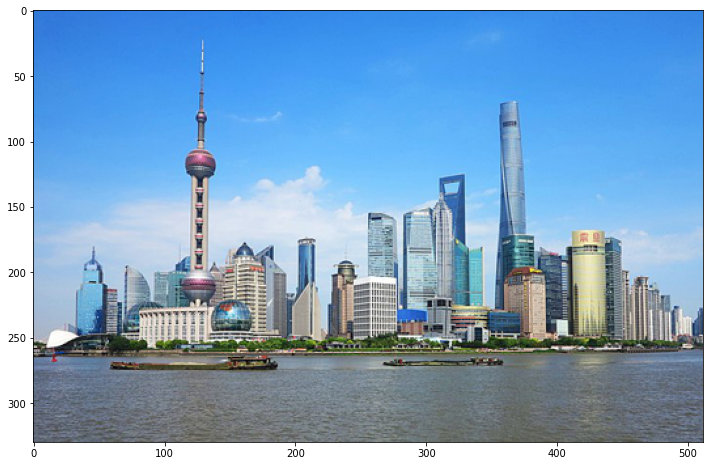

In [172]:
imshow(content_image)

In [175]:
sharpen_2(content_image)

array([[[[ 47, 120, 214],
         [ 48, 121, 215],
         [ 48, 121, 215],
         ...,
         [ 51, 131, 224],
         [ 52, 130, 222],
         [ 55, 132, 224]],

        [[ 48, 121, 215],
         [ 48, 121, 215],
         [ 48, 121, 215],
         ...,
         [ 57, 137, 230],
         [ 57, 133, 225],
         [ 56, 133, 225]],

        [[ 48, 121, 215],
         [ 48, 121, 215],
         [ 48, 121, 215],
         ...,
         [ 59, 138, 233],
         [ 52, 130, 226],
         [ 56, 133, 225]],

        ...,

        [[ 84,  95, 110],
         [ 91,  97, 112],
         [ 81,  93, 105],
         ...,
         [  0,   0,  14],
         [  3,  17,  24],
         [ 79,  88,  97]],

        [[ 90, 101, 115],
         [130, 136, 154],
         [102, 112, 129],
         ...,
         [127, 138, 163],
         [ 67,  78,  84],
         [ 83,  92,  98]],

        [[ 90, 101, 115],
         [ 90,  99, 114],
         [ 88,  98, 110],
         ...,
         [104, 116, 135],
        

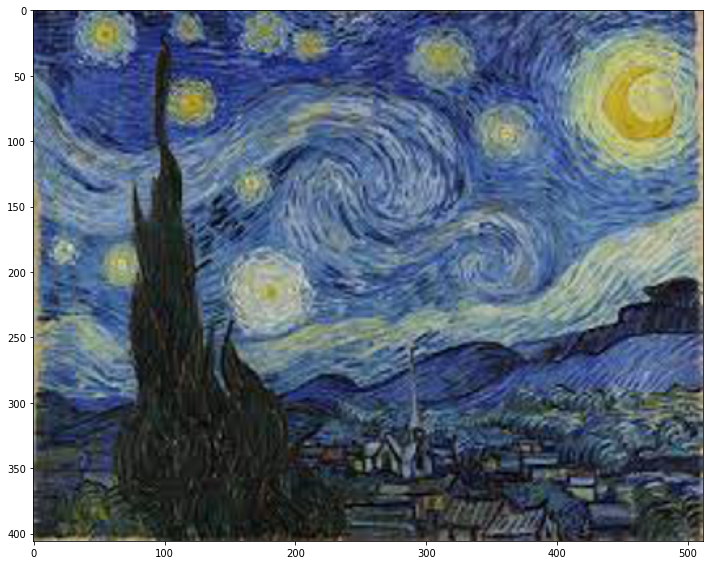

In [176]:
imshow(style_image)

In [163]:
vgg = tf.keras.applications.VGG16(include_top=True, weights='imagenet')


In [164]:
prediction_probabilities = vgg(vgg_input_resize('content_image/Shanghai.jpg'))


In [165]:

'''# select block5 conv 2 as content layer
content_layers = ['block5_conv2'] 

# select the following layers as style layer
style_layers = ['block1_conv1',
          'block2_conv1',
          'block3_conv1', 
          'block4_conv1', 
          'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)'''
# select block5 conv 2 as content layer
content_layers = ['block2_conv2'] 

# select the following layers as style layer
style_layers = [
          'block3_conv1', 
          'block4_conv1', 
          'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


In [166]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  print(outputs)

  model = tf.keras.Model([vgg.input], outputs)
  return model


In [177]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image)


[<tf.Tensor 'block3_conv1_6/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1_6/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1_6/Identity:0' shape=(None, None, None, 512) dtype=float32>]


In [158]:
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())


block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7117.1885
  mean:  119.088005
block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  14898.467
  mean:  465.81918
block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3132.2373
  mean:  38.81911


In [34]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  #input_shape = tf.shape(input_tensor)
  #num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  #result/(num_locations)
  return result


In [35]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    #inputs = inputs*255.0
    #preprocessed_input = tf.keras.applications.vgg16.preprocess_input(inputs)
    #outputs = self.vgg(preprocessed_input)
    outputs = self.vgg(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                        outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
              for style_output in style_outputs]

    content_dict = {content_name:value 
              for content_name, value 
              in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
            for style_name, value
            in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}


In [39]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


[<tf.Tensor 'block3_conv1_3/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1_3/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1_3/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block2_conv2_3/Identity:0' shape=(None, None, None, 128) dtype=float32>]
Styles:
   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  10412808000.0
    mean:  285628000.0

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  36480254000.0
    mean:  1152736400.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  165878690.0
    mean:  2890472.5

Contents:
   block2_conv2
    shape:  (1, 165, 256, 128)
    min:  0.0
    max:  6054.6206
    mean:  129.85077


In [210]:
style_targets = extractor(style_image/255)['style']
content_targets = extractor(content_image/255)['content']

image = tf.Variable(content_image/255,dtype=tf.float32)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [198]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def clip_0_255(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0)


In [91]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:

style_weight=1e-3
content_weight=1e4
variation_wight=30

#content_weight=10000
#style_weight=0.0001

def total_loss(outputs, alpha = 10000, beta = 0.1,style_W = style_weight,
         content_W = content_weight, variation_W = variation_wight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_sum((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers


    content_loss = tf.add_n([tf.reduce_sum((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    variation_loss = tf.image.total_variation(output)
    variation_loss *= variation_W


    loss = beta*style_loss + alpha*content_loss + variation_loss
    
    return loss


In [178]:
plain_image = tf.Variable(np.random.normal(size=tuple(x for x in image.shape)),dtype=tf.float32)

plain_image


<tf.Variable 'Variable:0' shape=(1, 330, 512, 3) dtype=float32, numpy=
array([[[[-0.31881398, -0.21393207,  0.7695    ],
         [ 1.1860845 , -0.86317664,  0.85065717],
         [ 0.11420359, -2.9879496 , -0.31622025],
         ...,
         [-0.4528192 ,  0.8367024 , -0.02101981],
         [ 0.07383609,  1.1052829 ,  0.53171635],
         [-0.42180854,  0.1353025 , -1.1873181 ]],

        [[-2.9729323 ,  0.19488043,  0.7824737 ],
         [-1.1990895 , -1.6609144 , -0.50497615],
         [-0.6228295 ,  0.5223231 ,  0.20530628],
         ...,
         [ 1.1547316 , -0.6298    , -0.90200263],
         [ 1.1662074 , -1.7004824 , -0.47969693],
         [ 0.8492478 , -0.8427814 , -0.45023668]],

        [[-0.17412671, -0.9735192 , -0.8995607 ],
         [-1.2792057 ,  0.06542014,  0.9326926 ],
         [ 1.753974  , -1.1131624 ,  0.00488917],
         ...,
         [-0.5430195 ,  1.2326709 ,  0.7443482 ],
         [ 0.19734119, -0.46736613,  0.8134569 ],
         [-1.3308333 ,  0.6045044

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    print(output)
    loss = total_loss(outputs, alpha=1000, beta = 0.1)
    print(loss)

  grad = tape.gradient(loss, image)
  print(grad)
  opt.apply_gradients([(grad,image)])
  #image.assign(clip_0_1(image))
  image.assign(clip_0_255(image))



In [222]:
image = tf.Variable(content_image/255,dtype=tf.float32)
image

<tf.Variable 'Variable:0' shape=(1, 330, 512, 3) dtype=float32, numpy=
array([[[[0.18431373, 0.47058824, 0.8392157 ],
         [0.1882353 , 0.4745098 , 0.84313726],
         [0.1882353 , 0.4745098 , 0.84313726],
         ...,
         [0.2       , 0.5137255 , 0.8784314 ],
         [0.20392157, 0.50980395, 0.87058824],
         [0.21568628, 0.5176471 , 0.8784314 ]],

        [[0.1882353 , 0.4745098 , 0.84313726],
         [0.1882353 , 0.4745098 , 0.84313726],
         [0.1882353 , 0.4745098 , 0.84313726],
         ...,
         [0.21568628, 0.5254902 , 0.8901961 ],
         [0.21568628, 0.52156866, 0.88235295],
         [0.21960784, 0.52156866, 0.88235295]],

        [[0.1882353 , 0.4745098 , 0.84313726],
         [0.1882353 , 0.4745098 , 0.84313726],
         [0.1882353 , 0.4745098 , 0.84313726],
         ...,
         [0.21960784, 0.5294118 , 0.89411765],
         [0.21568628, 0.52156866, 0.8862745 ],
         [0.21960784, 0.52156866, 0.88235295]],

        ...,

        [[0.32941177,

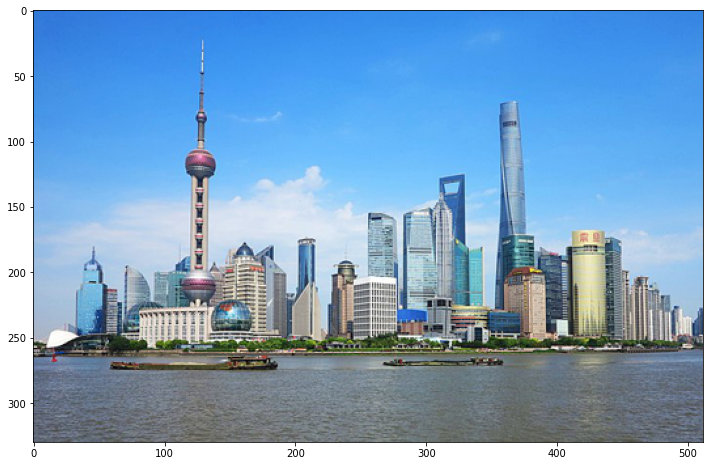

In [216]:
plt.imshow(np.squeeze(tf.cast(image*255,dtype=tf.int32).numpy()))


In [223]:
train_step(image)

tf.Tensor(
[[[[  53.17436    123.31327    287.40356   ...    0.
       0.           0.       ]
   [1162.1521       0.           0.        ...  425.99402
       0.           0.       ]
   [1240.3995      13.762383     0.        ...  362.13437
       0.           0.       ]
   ...
   [1291.2959     285.75916      0.        ...  376.887
       0.           0.       ]
   [1648.9303    1278.8408       0.        ...  422.8591
       0.           0.       ]
   [1442.59       358.95572      0.        ...  586.58136
       0.           0.       ]]

  [[   0.           0.         344.77124   ...    0.
     965.3614       0.       ]
   [ 524.36993      0.           0.        ...  480.77194
     359.32312    145.66049  ]
   [ 674.71686      0.           0.        ...  286.39917
      77.29547    340.73074  ]
   ...
   [ 710.52014      0.           0.        ...  315.2847
     393.9124     490.7401   ]
   [1303.1531    1368.352        0.        ...  388.50397
      58.83199    632.42633  ]
   [1562

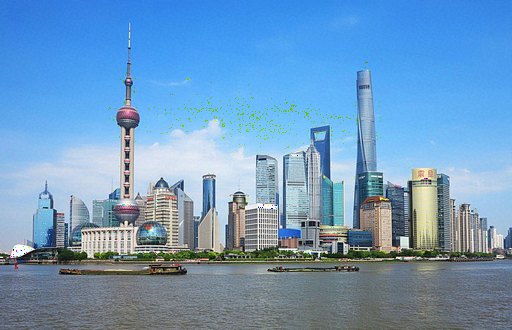

In [224]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image,True)

In [173]:
plain_image = tf.Variable(np.random.normal(size=tuple(x for x in image.shape)),dtype=tf.float32)
image = tf.Variable(content_image,dtype=tf.float32)

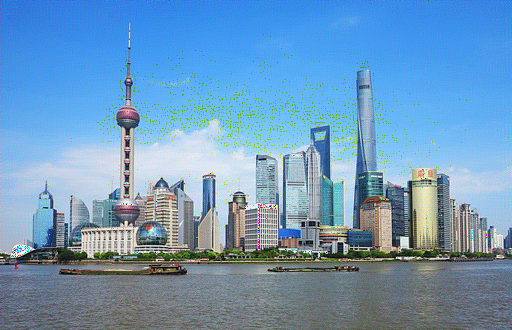

Train step: 900
............

KeyboardInterrupt: 

In [225]:
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image,True))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
